In [140]:
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os, sys, re, pickle, glob
from PIL import Image
import pathlib
import csv 
# sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras import layers
from keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')
import IPython.display as ipd

**Visualization of the Audio Files:**
In this section, we have read and plotted the MileEnd audio segments for better understanding of the samples.

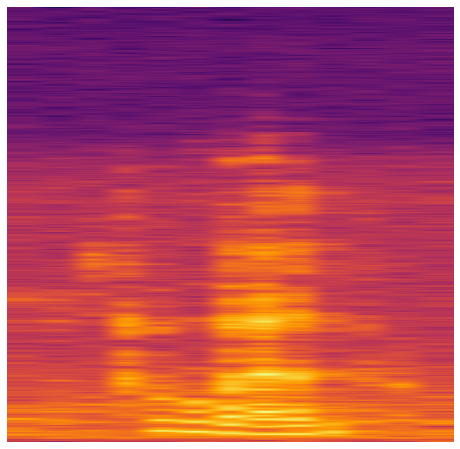

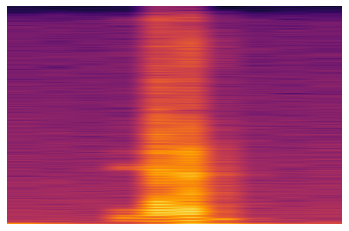

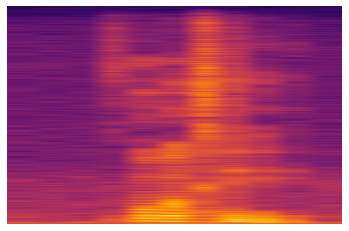

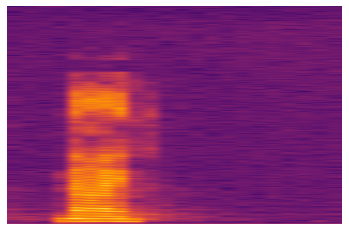

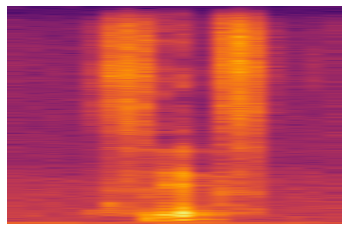

<Figure size 432x288 with 0 Axes>

In [142]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
files = glob.glob('/content/drive/MyDrive/QMUL/ML/Project/Data/MLEnd/training/*/*.wav')

intonations = 'neutral bored excited question'.split()
for filename in files[:5]:        
    y, sr = librosa.load(filename, mono=True, duration=5)
    plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
    plt.axis('off');
    plt.savefig(f'/content/drive/MyDrive/QMUL/ML/Project/Data/MLEnd/img_data/{os.path.basename(filename).replace(".wav", "")}.png')
    plt.show()

    # plt.figure(figsize=(14, 5))
    # librosa.display.waveplot(y, sr=sr)

    plt.clf()

**Data Preprocessing:**
Arranging all the feature header in this section.

In [11]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

print(header)

['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']


**Labels Processing:**
Loading all the labels into a variable to process and feed into our model.

In [35]:
labels = pd.read_csv('/content/drive/MyDrive/QMUL/ML/Project/Data/MLEnd/trainingMLEnd.csv')
labels['digit_label']

0         4
1         2
2        70
3         2
4         4
         ..
19995    90
19996    10
19997    90
19998    19
19999    20
Name: digit_label, Length: 20000, dtype: int64

In [36]:
labels['File ID']

0        0000000.wav
1        0000001.wav
2        0000002.wav
3        0000003.wav
4        0000004.wav
            ...     
19995    0019995.wav
19996    0019996.wav
19997    0019997.wav
19998    0019998.wav
19999    0019999.wav
Name: File ID, Length: 20000, dtype: object

**Feature Extraction:**
Extracting features from first 5000 audio files and saving them into a CSV file which in turn will be used as the input of our model.

In [107]:
new_dataset_path = '/content/drive/MyDrive/QMUL/ML/Project/Data/MLEnd/new_dataset.csv'
file = open(new_dataset_path, 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

digit_idx = 0
for filename in labels['File ID'][:5000]:
# for filename in files[:50]:    
    filename = f'/content/drive/MyDrive/QMUL/ML/Project/Data/MLEnd/training/Training/{filename}'
    y, sr = librosa.load(filename, mono=True, duration=30)
    digit_label = labels['digit_label'][digit_idx]
    digit_idx += 1
    # print(filename, '=>', digit_label)
    if (digit_label) > 9:
      continue

    # rmse = librosa.feature.rmse(y=y)
    rmse = librosa.feature.rms(y=y)[0]
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    filename2 = os.path.basename(filename)
    to_append = f'{filename2} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
    for e in mfcc:
        to_append += f' {np.mean(e)}'
    to_append += f' {digit_label}'
    file = open(new_dataset_path, 'a', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(to_append.split())     

**Visualizing Feature Data:**
Here we are visualing the features that were saved into a CSV file.

In [128]:
data = pd.read_csv(new_dataset_path)
data

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0000000.wav,0.463416,0.009657,2406.574812,2197.995732,4693.939209,0.159003,-615.650696,76.079506,14.183249,2.055386,-14.936810,-1.414083,-1.754389,0.165803,-7.749091,-12.595222,-5.167373,-4.739631,-4.016208,-7.628643,-7.643737,-6.141539,-1.972690,-5.131233,-6.140224,-3.352760,4
1,0000001.wav,0.498955,0.031027,2681.456753,2434.352641,5335.701069,0.155646,-326.022552,77.891144,-19.062096,21.070469,3.021273,2.141247,-4.021226,-2.159979,-7.786098,-1.169008,-5.357862,-3.352915,-1.678581,-7.583438,-5.102869,0.549777,-1.631977,5.485393,0.204081,-1.796568,2
2,0000003.wav,0.585279,0.031680,883.134345,1446.833328,1627.869907,0.027166,-452.457703,97.484871,25.988503,21.277096,17.212198,12.850103,17.728901,7.606271,1.237578,6.582763,3.111713,1.333293,-1.959630,5.519849,8.656970,3.106895,3.027153,7.707105,6.880334,6.574434,2
3,0000004.wav,0.418097,0.078083,1911.305590,1994.697128,3658.686967,0.105957,-359.200897,97.792557,10.582139,9.163197,14.097530,-0.814324,2.324103,1.685807,-8.576827,5.498129,-6.234785,-0.848851,1.803127,-1.293006,5.073626,2.455812,5.221500,-0.779512,1.331830,-3.515458,4
4,0000006.wav,0.570554,0.073354,2041.675442,1915.549197,4090.016602,0.118665,-366.935760,71.676834,6.974798,15.992710,-2.613075,5.743099,-7.719092,2.960069,-1.692857,0.917281,1.651239,0.788469,-0.471782,1.176938,5.195519,1.522602,7.699098,-1.407485,1.024862,1.623773,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,0004980.wav,0.550944,0.016201,2672.782103,2470.549512,5320.136719,0.163943,-423.249725,91.854546,-4.336356,10.213775,-11.536367,5.469718,-7.066447,-15.829291,-10.240484,-1.403503,-3.882104,4.021028,-20.069902,1.985336,-5.680486,-2.121344,-11.057442,0.023080,-4.899186,-9.141342,5
1639,0004987.wav,0.534166,0.042528,2489.920703,2299.195298,5072.145996,0.140723,-410.405518,74.536980,15.354648,27.739716,4.799693,20.930765,-26.683613,7.809555,3.054463,7.502905,-14.044116,-0.396450,-1.142776,-2.020223,4.885296,1.914973,-7.466367,-3.921437,-0.978427,-12.700093,0
1640,0004989.wav,0.361839,0.012499,2329.385101,2475.742663,4646.586100,0.102910,-517.672424,87.963860,20.581736,20.897615,6.349834,10.354372,9.180927,8.221931,-4.492185,-6.506035,-20.195711,-9.949172,-2.420154,-7.653937,-2.857329,0.451632,-4.443486,-1.984470,-2.061625,-4.379954,4
1641,0004994.wav,0.453665,0.078412,2452.796193,2244.057129,4692.538292,0.133849,-333.878143,72.934837,17.286661,8.576549,-18.035648,-5.446975,-3.063406,-13.724353,-8.097801,9.299220,-5.194222,-5.473136,-14.553962,-0.130019,-6.379641,-9.357118,-9.913054,-7.610573,-6.542076,-6.245990,7


**Feature Selection and Preparing Training & Test Data:**
In this section we remove all unncessary data from the feature CSV, transform them and split them to achieve Training & Test datasets.

In [108]:
data.head() # Dropping unneccesary columns
data = data.drop(['filename'],axis=1) # Encoding the Labels
digit_list = data.iloc[:, -1]
print(digit_list)
encoder = LabelEncoder()
y = encoder.fit_transform(digit_list) # Scaling the Feature columns
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float)) # Dividing data into training and Testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

0       4
1       2
2       2
3       4
4       2
       ..
1638    5
1639    0
1640    4
1641    7
1642    7
Name: label, Length: 1643, dtype: int64


**Visualizing the Features**

In [110]:
data.iloc[:, :-1]

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,0.463416,0.009657,2406.574812,2197.995732,4693.939209,0.159003,-615.650696,76.079506,14.183249,2.055386,-14.936810,-1.414083,-1.754389,0.165803,-7.749091,-12.595222,-5.167373,-4.739631,-4.016208,-7.628643,-7.643737,-6.141539,-1.972690,-5.131233,-6.140224,-3.352760
1,0.498955,0.031027,2681.456753,2434.352641,5335.701069,0.155646,-326.022552,77.891144,-19.062096,21.070469,3.021273,2.141247,-4.021226,-2.159979,-7.786098,-1.169008,-5.357862,-3.352915,-1.678581,-7.583438,-5.102869,0.549777,-1.631977,5.485393,0.204081,-1.796568
2,0.585279,0.031680,883.134345,1446.833328,1627.869907,0.027166,-452.457703,97.484871,25.988503,21.277096,17.212198,12.850103,17.728901,7.606271,1.237578,6.582763,3.111713,1.333293,-1.959630,5.519849,8.656970,3.106895,3.027153,7.707105,6.880334,6.574434
3,0.418097,0.078083,1911.305590,1994.697128,3658.686967,0.105957,-359.200897,97.792557,10.582139,9.163197,14.097530,-0.814324,2.324103,1.685807,-8.576827,5.498129,-6.234785,-0.848851,1.803127,-1.293006,5.073626,2.455812,5.221500,-0.779512,1.331830,-3.515458
4,0.570554,0.073354,2041.675442,1915.549197,4090.016602,0.118665,-366.935760,71.676834,6.974798,15.992710,-2.613075,5.743099,-7.719092,2.960069,-1.692857,0.917281,1.651239,0.788469,-0.471782,1.176938,5.195519,1.522602,7.699098,-1.407485,1.024862,1.623773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,0.550944,0.016201,2672.782103,2470.549512,5320.136719,0.163943,-423.249725,91.854546,-4.336356,10.213775,-11.536367,5.469718,-7.066447,-15.829291,-10.240484,-1.403503,-3.882104,4.021028,-20.069902,1.985336,-5.680486,-2.121344,-11.057442,0.023080,-4.899186,-9.141342
1639,0.534166,0.042528,2489.920703,2299.195298,5072.145996,0.140723,-410.405518,74.536980,15.354648,27.739716,4.799693,20.930765,-26.683613,7.809555,3.054463,7.502905,-14.044116,-0.396450,-1.142776,-2.020223,4.885296,1.914973,-7.466367,-3.921437,-0.978427,-12.700093
1640,0.361839,0.012499,2329.385101,2475.742663,4646.586100,0.102910,-517.672424,87.963860,20.581736,20.897615,6.349834,10.354372,9.180927,8.221931,-4.492185,-6.506035,-20.195711,-9.949172,-2.420154,-7.653937,-2.857329,0.451632,-4.443486,-1.984470,-2.061625,-4.379954
1641,0.453665,0.078412,2452.796193,2244.057129,4692.538292,0.133849,-333.878143,72.934837,17.286661,8.576549,-18.035648,-5.446975,-3.063406,-13.724353,-8.097801,9.299220,-5.194222,-5.473136,-14.553962,-0.130019,-6.379641,-9.357118,-9.913054,-7.610573,-6.542076,-6.245990


In [109]:
np.array(data.iloc[:, :-1], dtype = float)[0]

array([ 4.63415951e-01,  9.65711102e-03,  2.40657481e+03,  2.19799573e+03,
        4.69393921e+03,  1.59003364e-01, -6.15650696e+02,  7.60795059e+01,
        1.41832495e+01,  2.05538583e+00, -1.49368095e+01, -1.41408288e+00,
       -1.75438929e+00,  1.65802956e-01, -7.74909115e+00, -1.25952225e+01,
       -5.16737270e+00, -4.73963070e+00, -4.01620817e+00, -7.62864256e+00,
       -7.64373684e+00, -6.14153910e+00, -1.97269011e+00, -5.13123322e+00,
       -6.14022350e+00, -3.35276008e+00])

In [84]:
X_train

array([[ 1.20218638e+00, -8.26620026e-01,  1.50147930e+00, ...,
        -3.92327919e-01, -5.04517812e-01, -9.74920966e-01],
       [-6.86909625e-01, -3.40378524e-01,  1.27003503e+00, ...,
        -8.10132538e-01, -9.97358257e-02, -6.73202129e-01],
       [-9.15106713e-02,  1.87727490e-01, -2.38199705e-01, ...,
        -1.42797371e+00, -1.23756794e+00, -4.63161448e-01],
       ...,
       [-7.73206474e-01, -6.83488726e-04, -6.17527385e-01, ...,
         3.42781975e-01, -4.45211804e-01,  9.28441584e-01],
       [-9.46167270e-01,  1.79099806e+00,  6.98627274e-02, ...,
        -3.97536137e-01,  5.87571390e-01,  5.84292642e-01],
       [-3.74133333e-02, -9.56466135e-02, -7.05851323e-01, ...,
        -1.00604112e+00, -7.44977980e-01,  1.61318837e-01]])

**Checking the label data**

In [85]:
y

array([4, 2, 2, 4, 2, 1, 3, 6, 9, 9, 2, 5, 4, 7, 9, 1, 9, 9, 1, 9, 5, 4,
       5, 6, 3, 9, 7, 3, 5, 0, 6, 4, 9, 9, 0, 9, 0, 7, 3, 9, 1, 7, 1, 6,
       6, 3, 9, 9, 4, 7, 6, 8, 2, 8, 2, 3, 4, 1, 1, 0, 1, 3, 5, 5, 5, 1,
       1, 0, 2, 0, 2, 8, 2, 4, 2, 4, 9, 3, 6, 2, 5, 0, 1, 5, 7, 4, 8, 8,
       8, 6, 6, 0, 1, 4, 4, 6, 3, 3, 1, 8, 2, 5, 9, 3, 5, 6, 5, 0, 3, 6,
       8, 3, 3, 6, 3, 1, 4, 1, 6, 6, 8, 4, 1, 4, 8, 3, 9, 4, 6, 5, 6, 9,
       3, 8, 3, 4, 0, 2, 1, 3, 7, 9, 9, 9, 3, 4, 8, 7, 1, 7, 8, 0, 7, 1,
       6, 1, 8, 3, 4, 3, 3, 6, 3, 3, 7, 6, 1, 7, 7, 5, 7, 8, 7, 5, 8, 4,
       5, 3, 2, 8, 9, 7, 1, 8, 6, 6, 2, 0, 6, 3, 5, 9, 5, 7, 5, 3, 7, 9,
       0, 7, 5, 0, 9, 8, 8, 9, 7, 9, 8, 6, 5, 8, 6, 7, 0, 9, 6, 6, 4, 5,
       5, 9, 5, 6, 2, 7, 7, 6, 4, 4, 2, 1, 6, 3, 6, 0, 7, 4, 8, 1, 6, 6,
       0, 3, 4, 5, 0, 5, 7, 1, 4, 0, 4, 1, 7, 5, 5, 8, 6, 3, 5, 6, 2, 2,
       1, 8, 3, 0, 0, 1, 3, 6, 2, 0, 1, 0, 1, 3, 7, 8, 5, 9, 5, 6, 8, 0,
       8, 9, 6, 4, 4, 2, 9, 1, 6, 7, 3, 5, 2, 3, 1,

**Building the Model:**
Here we have built our model. This is an ANN model with activatation parameters in several layers.

In [111]:
model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

**Model Summary**

In [112]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 256)               6912      
_________________________________________________________________
dense_29 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_30 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 48,714
Trainable params: 48,714
Non-trainable params: 0
_________________________________________________________________


**Model Fitting and Classification:**
In this phase, we have fitted the model with training data for a number of 150 epochs with batch size of 128.

In [113]:
classifier = model.fit(X_train,
                    y_train,
                    epochs=150,
                    batch_size=128)

Epoch 1/150
11/11 [==============================] - 0s 3ms/step - loss: 2.2819 - accuracy: 0.1415
Epoch 2/150
11/11 [==============================] - 0s 3ms/step - loss: 2.0547 - accuracy: 0.2942
Epoch 3/150
11/11 [==============================] - 0s 3ms/step - loss: 1.8498 - accuracy: 0.3910
Epoch 4/150
11/11 [==============================] - 0s 3ms/step - loss: 1.6548 - accuracy: 0.4682
Epoch 5/150
11/11 [==============================] - 0s 3ms/step - loss: 1.4715 - accuracy: 0.5027
Epoch 6/150
11/11 [==============================] - 0s 3ms/step - loss: 1.3367 - accuracy: 0.5344
Epoch 7/150
11/11 [==============================] - 0s 4ms/step - loss: 1.2514 - accuracy: 0.5770
Epoch 8/150
11/11 [==============================] - 0s 4ms/step - loss: 1.2242 - accuracy: 0.5922
Epoch 9/150
11/11 [==============================] - 0s 4ms/step - loss: 1.1472 - accuracy: 0.6000
Epoch 10/150
11/11 [==============================] - 0s 3ms/step - loss: 1.0868 - accuracy: 0.6311
Epoch 11/

**Checking Accuracy Data**

In [129]:
train_accuracy=model.evaluate(X_train,y_train,verbose=0)
print(train_accuracy[1])

1.0


In [130]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.4832826852798462


In [91]:
X_test[1]

array([-0.61836616, -0.43694878,  0.02821237,  0.32992993,  0.18495049,
       -0.1460896 , -0.87511134, -0.36706685,  0.38006921, -0.04822279,
        1.17644153,  0.18574955,  0.81288517,  0.36536354,  0.42135924,
       -0.50806192, -0.61260098, -1.36376469, -1.02935056, -1.32443854,
       -0.84790776, -1.37855116, -0.67824422, -0.26107853, -0.28669745,
       -0.15293536])

**Testing the Model:**
We chose a random audio file from the MileEnd audio dataset and verified whether our model could predit the correct number.

In [125]:
filename = '0008039.wav' # digit file
filename = f'/content/drive/MyDrive/QMUL/ML/Project/Data/MLEnd/training/Training/{filename}'
y, sr = librosa.load(filename, mono=True, duration=30)

rmse = librosa.feature.rms(y=y)[0]
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
zcr = librosa.feature.zero_crossing_rate(y)
mfcc = librosa.feature.mfcc(y=y, sr=sr)
to_append = f'{np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
for e in mfcc:
    to_append += f' {np.mean(e)}'

data = np.array(to_append.split(), dtype = float)
print(data)

[ 4.85848099e-01  1.93332713e-02  1.75563777e+03  2.14273670e+03
  3.82323384e+03  6.38844937e-02 -5.23734131e+02  8.29670181e+01
  6.46044874e+00  1.32291260e+01  1.62047768e+01  1.45130739e+01
  1.05986176e+01  1.56445813e+00  3.77283478e+00 -3.14707732e+00
 -1.25416346e+01 -1.08303995e+01 -1.04065943e+01 -2.08926177e+00
 -7.06236172e+00 -1.27922797e+00 -2.70969570e-01 -7.35016227e-01
 -1.79731965e+00 -4.32621193e+00]


**Reshaping the Test Input and Pulling the Prediction Values**

In [126]:
data_reshaped = data.reshape(1,-1)
predicted_label=model.predict_classes(data_reshaped)
print(predicted_label)

[9]


In [127]:
prediction_class = encoder.inverse_transform(predicted_label) 
prediction_class

array([9])